# OTA Room Price Analysis

### Execute the cell below once to turn off debugging

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

## Defined list of room types

In [245]:

''' compute the semantic similarity of each trigram to each _axiom_room_types '''

''' assign the room type of _axiom_room_types with the highest semantic similarity '''

' assign the room type of _axiom_room_types with the highest semantic similarity '

## Read data from OTA properties table

In [2]:
import os
import sys
import pandas as pd
from datetime import datetime, date, timedelta

ROOT_DIR = "/home/nuwan/workspace/rezgate/wrangler/"
UTILS_DIR = "/home/nuwan/workspace/rezgate/utils/"
DATA_DIR = os.path.join(ROOT_DIR,"data/hospitality/bookings/")
sys.path.insert(1, UTILS_DIR)
import sparkWorkLoads as spark

if debug:
    import importlib
    spark = importlib.reload(spark)

kwargs = {
    "UTILS_DIR":UTILS_DIR,
}

clsSparkWL = spark.SparkWorkLoads(desc="ota property room prices", **kwargs)
#_session = clsSparkWL.get_spark_session()

All packages in SparkWorkLoads loaded successfully!
All packages in SparkWorkLoads loaded successfully!
22/09/28 10:00:29 WARN Utils: Your hostname, FarmRaiderTester resolves to a loopback address: 127.0.1.1; using 192.168.124.15 instead (on interface enp2s0)
22/09/28 10:00:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/09/28 10:00:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Initialing SparkWorkLoads class for sparkWorkLoads with instance ota property room prices
Logging SparkWorkLoads info, warnings, and error to /home/nuwan/workspace/rezgate/utils/logs/app.log


In [237]:
''' get the dataframe in pandas '''
kwargs = {"TO_PANDAS":True}
_s_tbl_name = "ota_property_prices"
data = clsSparkWL.get_data_from_table(dbTable=_s_tbl_name,**kwargs)
print(data.info())

Wait a moment, retrieving data ...
Loading complete!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8534 entries, 0 to 8533
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uuid              0 non-null      float64       
 1   ota_name          5850 non-null   object        
 2   search_dt         8534 non-null   datetime64[ns]
 3   property_name     8534 non-null   object        
 4   checkin_date      8534 non-null   datetime64[ns]
 5   checkout_date     0 non-null      datetime64[ns]
 6   room_type         8534 non-null   object        
 7   room_rate         8207 non-null   float64       
 8   currency          8534 non-null   object        
 9   review_score      8219 non-null   float64       
 10  destination_id    8534 non-null   object        
 11  destination_name  8534 non-null   object        
 12  location_desc     8534 non-null   object        
 13  other_info        8534 no

In [238]:
import nltk

def remove_adj(sentence):
    
    stop_tags = ["JJ", "JJR", "JJS", "NN"]
    tokens = nltk.word_tokenize(sentence)
    tags = list(reversed(nltk.pos_tag(tokens)))
    noun_located = False
    stop_reached = False
    final_sent = ''

    for word,pos in tags:
        if noun_located == False and pos == 'NN':
            noun_located = True
            final_sent+=f' {word}'
        elif stop_reached == False and pos in stop_tags:
            stop_reached = True
        elif stop_reached == True:
            final_sent+=f' {word}'

    final_sent = ' '.join(reversed(final_sent.split(' ')))      
    return final_sent

x = remove_adj('what is the mean of profit')
print(x)

what is the profit 


## Prep the data with word reduction

In [286]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
import re

_room_rate_df = data.copy()
# _room_rate_df['new_room_type'] = _room_rate_df['room_type']
# _room_rate_df['new_room_type'] = _room_rate_df['room_type']+" "+\
#                                 _room_rate_df['destination_name']+" "+\
#                                 _room_rate_df['location_desc']
''' remove all the stop words'''
_room_rate_df['new_room_type'] = _room_rate_df['room_type']\
                                .apply(lambda x: ' '\
                                       .join([word for word in x.split()\
                                              if word not in (stop)]))
# _room_rate_df['new_room_type'] = _room_rate_df['new_room_type']\
#                                 .apply(lambda x: ' '\
#                                        .join([word for word in x.split()\
#                                               if word not in (stop)]))
''' convert all words to lowercase '''
_room_rate_df['new_room_type']=_room_rate_df['new_room_type'].str.lower()

''' list of values to replace with a space '''
replace_word_dict = [r'-',r'/',r'[0-9]',r'[aA]ccess+',r'[aA]ccessible',r'[bB]ath',\
                     r'[dD]isability', r'[dD]isabilities',r'[fF]ree+',r'[hH]earing',\
                     r'[lL]ot',r'[mM]obility',r'[nN]on',r'[/]non',\
                     r'[sS]hower+',r'[Ss]moke+',r'[sS]moking',r'[sS]ofa',\
                     r'[tT]ub',]
''' remove unnecessary terms and reduce the blank spaces to one'''
_room_rate_df['new_room_type'].replace(to_replace=replace_word_dict, value=' ', regex=True, inplace=True)
''' replace duplicate words with a single word '''
_room_rate_df['new_room_type'].replace(to_replace=r'\b(\w+)(\s+\1)+\b', value=r'\1', inplace=True)
''' TODO replace adjectives wit spaces'''
#_room_rate_df['new_room_type'] = _room_rate_df['new_room_type'].apply(remove_adj)
''' strip the left and right spaces '''
_room_rate_df['new_room_type']=_room_rate_df['new_room_type'].str.strip()
#re.sub('\n+', ' ', (_flight_times[0]).lstrip().rstrip())
print('Processed room rate column for %d rows' % _room_rate_df.shape[0] )
print(_room_rate_df['new_room_type'].unique())

Processed room rate column for 8534 rows
['king room' 'double room two double beds'
 'business king room - smoke free' ... 'one-bedroom king suite pool view'
 'studio, studio, 1 king' 'ocean view premier king bed']


In [ ]:
double room two double beds = bigram((double room two),(room two double), (two double))

## create a set of trigrams for each row

In [258]:
from nltk import trigrams, bigrams
from collections import Counter
y= 'double room two double beds   parking   view'
L = [x for x in _room_rate_df['new_room_type'].unique() for x in bigrams(x.split())]
c = Counter(L)
print(c)
top = c.most_common(20)
#print(top)

Counter({('king', 'room'): 144, ('queen', 'room'): 118, ('room', 'two'): 88, ('queen', 'beds'): 87, ('two', 'queen'): 80, ('guest', 'room,'): 68, ('city', 'view'): 66, ('double', 'room'): 63, ('double', 'beds'): 63, ('king', 'bed'): 59, ('two', 'double'): 58, ('one', 'bedroom'): 46, ('king', 'suite'): 40, ('queen', 'bed'): 30, ('dormitory', 'room'): 29, ('deluxe', 'king'): 27, ('room,', 'king'): 27, ('suite', 'two'): 25, ('roll', 'in'): 24, ('room', 'ible'): 23, ('queen', 'suite'): 23, ('studio', 'suite'): 23, ('bedroom', 'suite'): 23, ('bed', 'bed'): 20, ('room', 'shared'): 20, ('shared', 'room'): 20, ('deluxe', 'queen'): 19, ('guest', 'room'): 19, ('room,', 'guest'): 19, ('king', 'studio'): 18, ('room', 'king'): 18, ('room', 'city'): 18, ('room', 'roll'): 17, ('room,', 'king,'): 17, ('standard', 'room'): 16, ('ocean', 'view'): 16, ('deluxe', 'room'): 15, ('one', 'king'): 15, ('standard', 'king'): 14, ('queen', 'studio'): 14, ('two', 'bedroom'): 14, ('beds', 'ible'): 14, ('(no', 'reso

In [293]:
import nltk
import difflib

_room_desc = pd.read_csv(os.path.join(DATA_DIR,"room_descriptions.csv"), delimiter=',')
_l_result = []

for text in _room_rate_df['new_room_type'][0:99]:
    max_seq_dist = -1
    best_seq_desc = None
    max_edit_dist = 100
    best_edit_desc = None
    for desc in _room_desc['description']:
        seq = difflib.SequenceMatcher(None,text,desc)
        seq_d = seq.ratio()*100
        edit_d = nltk.edit_distance(text,desc)
        if seq_d > max_dist:
            max_seq_dist = seq_d
            best_seq_desc = desc
        if edit_d < max_edit_dist:
            max_edit_dist = edit_d
            best_edit_desc = desc
    _l_result.append({ 'room_type':text,
                      'seq_desc':best_seq_desc,
                      'seq_dist':max_seq_dist,
                      'edit_desc':best_edit_desc,
                      'edit_dist':max_edit_dist,
                     })

In [294]:
result_df = pd.DataFrame(_l_result)
result_df

,room_type,seq_desc,seq_dist,edit_desc,edit_dist
0,king room,None,-1.000000,double room,6
1,king room,None,-1.000000,double room,6
2,double room two double beds,superior double room king beds,59.649123,double room double beds,4
3,business king room - smoke free,None,-1.000000,guest room double bed,19
4,double room two double beds - parking lot view,standard double room two double beds,65.853659,double room double beds,23
...,...,...,...,...,...
94,double suite two double beds - non-smoking,double room double beds,61.538462,double room double beds,23
95,king room,None,-1.000000,double room,6
96,studio queen room non-smoking,None,-1.000000,double room double beds,19
97,king room,None,-1.000000,double room,6


In [269]:
from nltk import trigrams, bigrams, word_tokenize
from collections import Counter

for text in _room_rate_df['new_room_type']:
    print(text)
    nltk_tokens = word_tokenize(text)
    L=list(nltk.bigrams(nltk_tokens))
    ''' compute the embedding score '''
    print(L)

king room
[('king', 'room')]
king room
[('king', 'room')]
double room two double beds
[('double', 'room'), ('room', 'two'), ('two', 'double'), ('double', 'beds')]
business king room
[('business', 'king'), ('king', 'room')]
double room two double beds   parking   view
[('double', 'room'), ('room', 'two'), ('two', 'double'), ('double', 'beds'), ('beds', 'parking'), ('parking', 'view')]
deluxe king room
[('deluxe', 'king'), ('king', 'room')]
standard king room
[('standard', 'king'), ('king', 'room')]
deluxe king room
[('deluxe', 'king'), ('king', 'room')]
queen room two queen beds
[('queen', 'room'), ('room', 'two'), ('two', 'queen'), ('queen', 'beds')]
queen studio
[('queen', 'studio')]
standard room two double beds
[('standard', 'room'), ('room', 'two'), ('two', 'double'), ('double', 'beds')]
deluxe queen room
[('deluxe', 'queen'), ('queen', 'room')]
king room
[('king', 'room')]
king suite
[('king', 'suite')]
king room
[('king', 'room')]
king room
[('king', 'room')]
king room      ible


[('king', 'room'), ('room', '('), ('(', 'no'), ('no', 'resort'), ('resort', 'fee'), ('fee', ')')]
king room
[('king', 'room')]
deluxe room one king bed
[('deluxe', 'room'), ('room', 'one'), ('one', 'king'), ('king', 'bed')]
king room
[('king', 'room')]
queen studio two queen beds      ible
[('queen', 'studio'), ('studio', 'two'), ('two', 'queen'), ('queen', 'beds'), ('beds', 'ible')]
king room
[('king', 'room')]
king suite   bed
[('king', 'suite'), ('suite', 'bed')]
bedroom suite,   queen,  bed
[('bedroom', 'suite'), ('suite', ','), (',', 'queen'), ('queen', ','), (',', 'bed')]
king room
[('king', 'room')]
king room (no resort fee)
[('king', 'room'), ('room', '('), ('(', 'no'), ('no', 'resort'), ('resort', 'fee'), ('fee', ')')]
standard queen room two queen beds
[('standard', 'queen'), ('queen', 'room'), ('room', 'two'), ('two', 'queen'), ('queen', 'beds')]
queen room two queen beds
[('queen', 'room'), ('room', 'two'), ('two', 'queen'), ('queen', 'beds')]
double room two double beds
[(

[('king', 'room')]
deluxe queen room
[('deluxe', 'queen'), ('queen', 'room')]
single room
[('single', 'room')]
standard king studio
[('standard', 'king'), ('king', 'studio')]
superior queen room
[('superior', 'queen'), ('queen', 'room')]
deluxe double room
[('deluxe', 'double'), ('double', 'room')]
premium double room two double beds
[('premium', 'double'), ('double', 'room'), ('room', 'two'), ('two', 'double'), ('double', 'beds')]
king room
[('king', 'room')]
king room
[('king', 'room')]
queen room    ible
[('queen', 'room'), ('room', 'ible')]
guest room,   king
[('guest', 'room'), ('room', ','), (',', 'king')]
deluxe king room          ible
[('deluxe', 'king'), ('king', 'room'), ('room', 'ible')]
ible king
[('ible', 'king')]
superior queen
[('superior', 'queen')]
traditional, guest room,   queen
[('traditional', ','), (',', 'guest'), ('guest', 'room'), ('room', ','), (',', 'queen')]
king room balcony
[('king', 'room'), ('room', 'balcony')]
one king bed standard
[('one', 'king'), ('ki

[('standard', 'king'), ('king', 'room')]
king room roll in          ible
[('king', 'room'), ('room', 'roll'), ('roll', 'in'), ('in', 'ible')]
king room
[('king', 'room')]
king studio suite     acces
[('king', 'studio'), ('studio', 'suite'), ('suite', 'acces')]
king room
[('king', 'room')]
luxury king room
[('luxury', 'king'), ('king', 'room')]
queen room
[('queen', 'room')]
double room
[('double', 'room')]
standard king room
[('standard', 'king'), ('king', 'room')]
handicap  ible room
[('handicap', 'ible'), ('ible', 'room')]
executive queen room
[('executive', 'queen'), ('queen', 'room')]
newly renovated standard   full
[('newly', 'renovated'), ('renovated', 'standard'), ('standard', 'full')]
room selected check in
[('room', 'selected'), ('selected', 'check'), ('check', 'in')]
standard double room
[('standard', 'double'), ('double', 'room')]
superior queen room
[('superior', 'queen'), ('queen', 'room')]
king room
[('king', 'room')]
urban   queen bed
[('urban', 'queen'), ('queen', 'bed'

[('penthouse', 'apartment')]
studio suite
[('studio', 'suite')]
king room
[('king', 'room')]
king studio   bed
[('king', 'studio'), ('studio', 'bed')]
deluxe queen room two queen beds
[('deluxe', 'queen'), ('queen', 'room'), ('room', 'two'), ('two', 'queen'), ('queen', 'beds')]
four bedroom house
[('four', 'bedroom'), ('bedroom', 'house')]
holiday home
[('holiday', 'home')]
two bedroom apartment
[('two', 'bedroom'), ('bedroom', 'apartment')]
single room
[('single', 'room')]
queen room
[('queen', 'room')]
king room lake view
[('king', 'room'), ('room', 'lake'), ('lake', 'view')]
standard king room
[('standard', 'king'), ('king', 'room')]
king room
[('king', 'room')]
ible studio suite king
[('ible', 'studio'), ('studio', 'suite'), ('suite', 'king')]
king suite trundle bed
[('king', 'suite'), ('suite', 'trundle'), ('trundle', 'bed')]
premium king room city view
[('premium', 'king'), ('king', 'room'), ('room', 'city'), ('city', 'view')]
queen studio suite city view
[('queen', 'studio'), ('

[('deluxe', 'king'), ('king', 'room')]
deluxe double room
[('deluxe', 'double'), ('double', 'room')]
queen room      ible
[('queen', 'room'), ('room', 'ible')]
queen
[]
petite room one queen bed
[('petite', 'room'), ('room', 'one'), ('one', 'queen'), ('queen', 'bed')]
standard king room
[('standard', 'king'), ('king', 'room')]
deluxe king room
[('deluxe', 'king'), ('king', 'room')]
studio,   queen
[('studio', ','), (',', 'queen')]
quadruple room  room
[('quadruple', 'room'), ('room', 'room')]
queen room
[('queen', 'room')]
standard room
[('standard', 'room')]
queen room
[('queen', 'room')]
family suite
[('family', 'suite')]
deluxe king room
[('deluxe', 'king'), ('king', 'room')]
queen room
[('queen', 'room')]
king room  ible
[('king', 'room'), ('room', 'ible')]
piazza queen queen room
[('piazza', 'queen'), ('queen', 'queen'), ('queen', 'room')]
guest room,   queen, city view
[('guest', 'room'), ('room', ','), (',', 'queen'), ('queen', ','), (',', 'city'), ('city', 'view')]
guest room t

[('queen', 'room'), ('room', 'two'), ('two', 'queen'), ('queen', 'beds')]
king room
[('king', 'room')]
queen suite two queen beds
[('queen', 'suite'), ('suite', 'two'), ('two', 'queen'), ('queen', 'beds')]
king studio
[('king', 'studio')]
deluxe double room
[('deluxe', 'double'), ('double', 'room')]
king room
[('king', 'room')]
queen room
[('queen', 'room')]
king room
[('king', 'room')]
standard double room
[('standard', 'double'), ('double', 'room')]
standard king room
[('standard', 'king'), ('king', 'room')]
guest room,   king bed
[('guest', 'room'), ('room', ','), (',', 'king'), ('king', 'bed')]
king room   bed
[('king', 'room'), ('room', 'bed')]
single room shared  room
[('single', 'room'), ('room', 'shared'), ('shared', 'room')]
king room
[('king', 'room')]
king room
[('king', 'room')]
two bedroom family room
[('two', 'bedroom'), ('bedroom', 'family'), ('family', 'room')]
captivating city view king
[('captivating', 'city'), ('city', 'view'), ('view', 'king')]
bedroom
[]
king room


In [289]:
from sematch.semantic.similarity import WordNetSimilarity
wns = WordNetSimilarity()
wns.word_similarity('dog', 'cat', 'li')

ModuleNotFoundError: No module named 'sematch'

In [225]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

c_df = pd.DataFrame(sorted(c.items(),key=lambda x:x[1],reverse=False), columns = ['trigram','count'])
c_df['trigram'] = list(c_df['trigram'].astype(str))
c_df['trigram'] = c_df['trigram'].str.replace('(','')
c_df['trigram'] = c_df['trigram'].str.replace(')','')
c_df['trigram'] = c_df['trigram'].str.replace(',','')
c_df['trigram'] = c_df['trigram'].str.replace("'","")
# c_df['trigram'] = c_df['trigram'].apply(lambda x: ' '.join(sorted(x.split())))
gc_df = c_df.groupby('trigram').aggregate(np.sum)
gc_df.sort_values(by='count', ascending=False, inplace=True)
top_df = gc_df.loc[gc_df['count']>10]
top_df.to_csv(os.path.join(ROOT_DIR,'data/tmp/','room_types'))

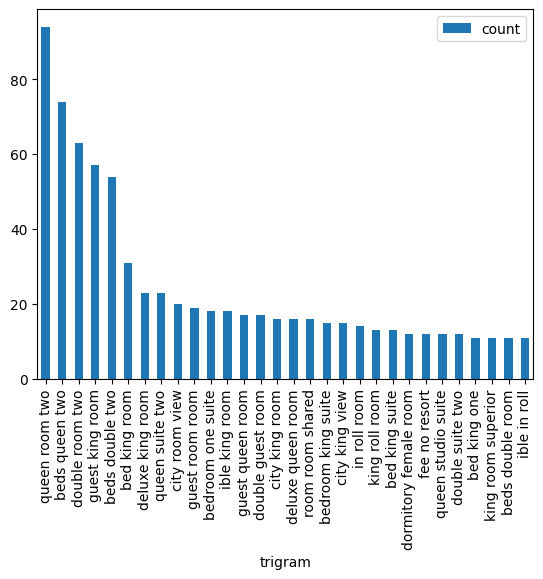

In [217]:
top_df.plot.bar()
plt.xticks(rotation='vertical')
plt.show()

## Initialize OTA Scraper Class
Required to extract the data from the Wrangler

In [10]:
import sys
sys.path.insert(1, '../../lib/wrangler')
import otaWebScraper as otaws
import clean as clean
import enrich as enrich
import datetime

dataDirPath="../../data/hospitality/bookings/scraper/"

if debug:
    import importlib
    otaws = importlib.reload(otaws)
    clean = importlib.reload(clean)
    enrich = importlib.reload(enrich)

_dataName = "booking_search_data"

clsScraper = otaws.OTAWebScraper(name=_dataName)
clsCleaner = clean.DataClensing(name=_dataName)
clsEnrich = enrich.DataEnrichment(name=_dataName)

All packages in OTAWebScraper loaded successfully!
All packages in DataClensing loaded successfully!
All packages in OTAWebScraper loaded successfully!
Initialing OTAWebScraper class for  booking_search_data
Initialing DataEnrichment class for  booking_search_data
Initialing DataEnrichment class for  booking_search_data


## Load the data

In [11]:
#../../data/hospitality/bookings/scraper/rates/2022-9-7-9-0/
#dirPath = _current_search_data_dir
dirPath = dataDirPath+"rates/2022-9-7-9-0/"
removed_files = clsScraper.remove_empty_files(dirPath)
if len(removed_files) > 0:
    print("%d files removed" %len(removed_files))
kwargs = {"columns" : ["search_datetime",
                       "checkin_date",
                       "propery_name",
                       "room_type",
                       "room_rate",
                       "review_score",
                       "destination_id",
                       "location",
                       "other"]}

rates_df = clsScraper.read_folder_csv_to_df(dirPath, **kwargs)
dtype_dict = {"search_datetime": "datetime64[ns]",
              "checkin_date": "datetime64[D]",
              "propery_name": "string",
              "room_type": "string",
              "room_rate": "string",
              "review_score": "float64",
              "destination_id": "string",
              "location": "string",
              "other" : "string"
             }
''' set the desired data types '''
rates_df = rates_df.astype(dtype_dict)
#rates_df.info()

In [5]:
''' drop duplicate rows '''
import pandas as pd

#print(rates_df.shape)

_distinct_df = pd.DataFrame()
_distinct_df = clsCleaner.drop_duplicates(rates_df)
#print(_distinct_df.shape)
''' round search datetime to nearest 30 min'''
_distinct_df['search_datetime']=_distinct_df['search_datetime'].dt.round('30min')

## Augment with datetime columns

In [6]:
''' Augment the DateTime columns with listed new columns '''
_dict_col_to_aug = {"DateTime" :   # type of datetime columns to augment the dataframe
                    ["YYYY",       # 4 digit year (int)
                     "DD",         # day as 1 digit and 2 digit if abbreviation = true
                     "MM",         # month as 1 digit and 2 digit if abbreviation = true
                     "MMM",        # month as name or 3 letters if abbreviation = True
                     "DOW",        # day-of-week name or 3 letter if abbreviation = True
                     "MMM-DD",     # three letter two digit month and two digit day (e.g. [09]Sep-10)
                     "HH-mm",      # two digit hour and minute
                    ]
                   }
_kwargs = {"dt_col_name" : "search_datetime",    # identifies the datetime column in the dataframe
           "pad_lead_zeros" : True,   # truncates the string to give 3 character names for year, month, dow
           "abbreviate" : True,
           "sorted_by" : ["YYYY","MM","DD"]
          }
_enriched_df = clsEnrich.get_enriched_data(_distinct_df,
                                           col_augment_dict = _dict_col_to_aug,
                                           **_kwargs
                                          )
_aug_cols = _dict_col_to_aug["DateTime"]
_distinct_df[_aug_cols] = _enriched_df[_aug_cols]

''' sort by date '''
_distinct_df = _distinct_df.sort_values(by=["YYYY","MM","DD"],kind='quicksort')
#print(_distinct_df.head())
print("\nEnrichment Complete!")
print(_distinct_df.shape)
print(_distinct_df.info())

Columns to augment to dataframe:
 {'DateTime': ['YYYY', 'DD', 'MM', 'MMM', 'DOW', 'MMM-DD', 'HH-mm']}

Enrichment Complete!
(2258, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 0 to 2257
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   search_datetime  2258 non-null   datetime64[ns]
 1   checkin_date     2258 non-null   datetime64[ns]
 2   propery_name     2258 non-null   string        
 3   room_type        2258 non-null   string        
 4   room_rate        2258 non-null   string        
 5   review_score     2258 non-null   float64       
 6   destination_id   2258 non-null   string        
 7   location         2258 non-null   string        
 8   other            2258 non-null   string        
 9   YYYY             2258 non-null   int64         
 10  DD               2258 non-null   object        
 11  MM               2258 non-null   object        
 12  MMM        

In [9]:
_distinct_df['room_rate'].unique()
#_distinct_df['search_datetime'].unique()

<StringArray>
[  'US$629',   'US$409',   'US$659',   'US$599',   'US$589',   'US$524',
   'US$665',   'US$749',   'US$469',   'US$559',
 ...
 'US$2,960',   'US$223',    'US$40',   'US$232',   'US$280', 'US$1,051',
   'US$430',   'US$112',   'US$300',   'US$310']
Length: 451, dtype: string

* [Consider clustering with SOM](https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering/notebook)
* [Time-series segmentation](https://www.kaggle.com/code/zonnalobo/timeseries-segmentation-and-forecasting/notebook)

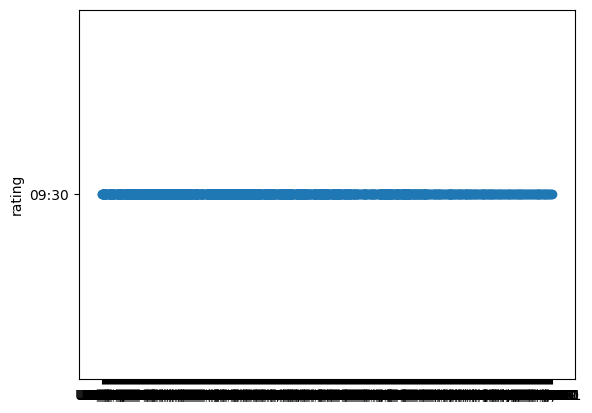

In [8]:
import matplotlib.pyplot as plt

plt.scatter(_distinct_df['room_rate'],_distinct_df['HH-mm'])
plt.ylabel('rating')
plt.show()